<a href="https://colab.research.google.com/github/HiteshAI/Projects/blob/master/vehicle_type_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Download data from kaggle to gdrive and make it ready for submission to kaggle directly**

In [0]:

from google.colab import drive
from pathlib import Path
drive.mount('/content/drive')

In [0]:
# from google.colab import files
# files.upload()  #this will prompt you to upload the kaggle.json

In [0]:
# !pip install -q kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !ls ~/.kaggle
# !chmod 600 /root/.kaggle/kaggle.json  # set permission

In [0]:
# !pip3 install --upgrade kaggle

In [0]:
path= '/content/drive/My Drive/vehicle_classification'
path = Path(path)
data_path = path/'vehicle_classification_dataset'
model_path= path/'models'
# !kaggle competitions download -c understanding_cloud_organization -p /content/drive/My\ Drive/cloud_formation/cloud_formation_dataset
# !kaggle competitions download vehicle -p /content/drive/My\ Drive/vehicle_classification/vehicle_classification_dataset -o

In [0]:
# !unzip -q -n /content/drive/My\ Drive/vehicle_classification/vehicle_classification_dataset/vehicle.zip -d /content/drive/My\ Drive/vehicle_classification/vehicle_classification_dataset

In [0]:
# !unzip -q -n /content/drive/My\ Drive/vehicle_classification/vehicle_classification_dataset/train.zip -d /content/drive/My\ Drive/vehicle_classification/vehicle_classification_dataset/train

In [0]:
# !unzip -q -n /content/drive/My\ Drive/vehicle_classification/vehicle_classification_dataset/test.zip -d /content/drive/My\ Drive/vehicle_classification/vehicle_classification_dataset/test

In [0]:

%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
import pandas as pd
from fastai.metrics import error_rate
from fastai.callbacks import *
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")


# from google.colab import drive
# from pathlib import Path
# drive.mount('/content/drive')
# path= '/content/drive/My Drive/plant_seedlings'
# path = Path(path)
# data_path = path/'plant_seedling_extract'
# model_path= path/'models'
# data_path


In [0]:
def get_data(bs, sz):
  # tfms = get_transforms(do_flip=True, flip_vert=True, max_warp=0., max_zoom=1.1, max_lighting=0.2)
  tfms = get_transforms()
  data = (ImageList.
                  from_folder(f'{data_path}').
                  filter_by_folder(include=['train']).
                  use_partial_data(sample_pct=0.1).
                  split_by_rand_pct(valid_pct = 0.2, seed=42).
                  label_from_folder().
                  add_test_folder().
                  transform(tfms,size=sz).
                  databunch(bs=bs, num_workers=0)   
               )
  data.show_batch(rows=3, figsize=(15,15))
  print(data.classes)
  print(len(data.classes)),data.c
  data.label_list
  data.normalize
  return data

['Ambulance', 'Barge', 'Bicycle', 'Boat', 'Bus', 'Car', 'Cart', 'Caterpillar', 'Helicopter', 'Limousine', 'Motorcycle', 'Segway', 'Snowmobile', 'Tank', 'Taxi', 'Truck', 'Van']
17


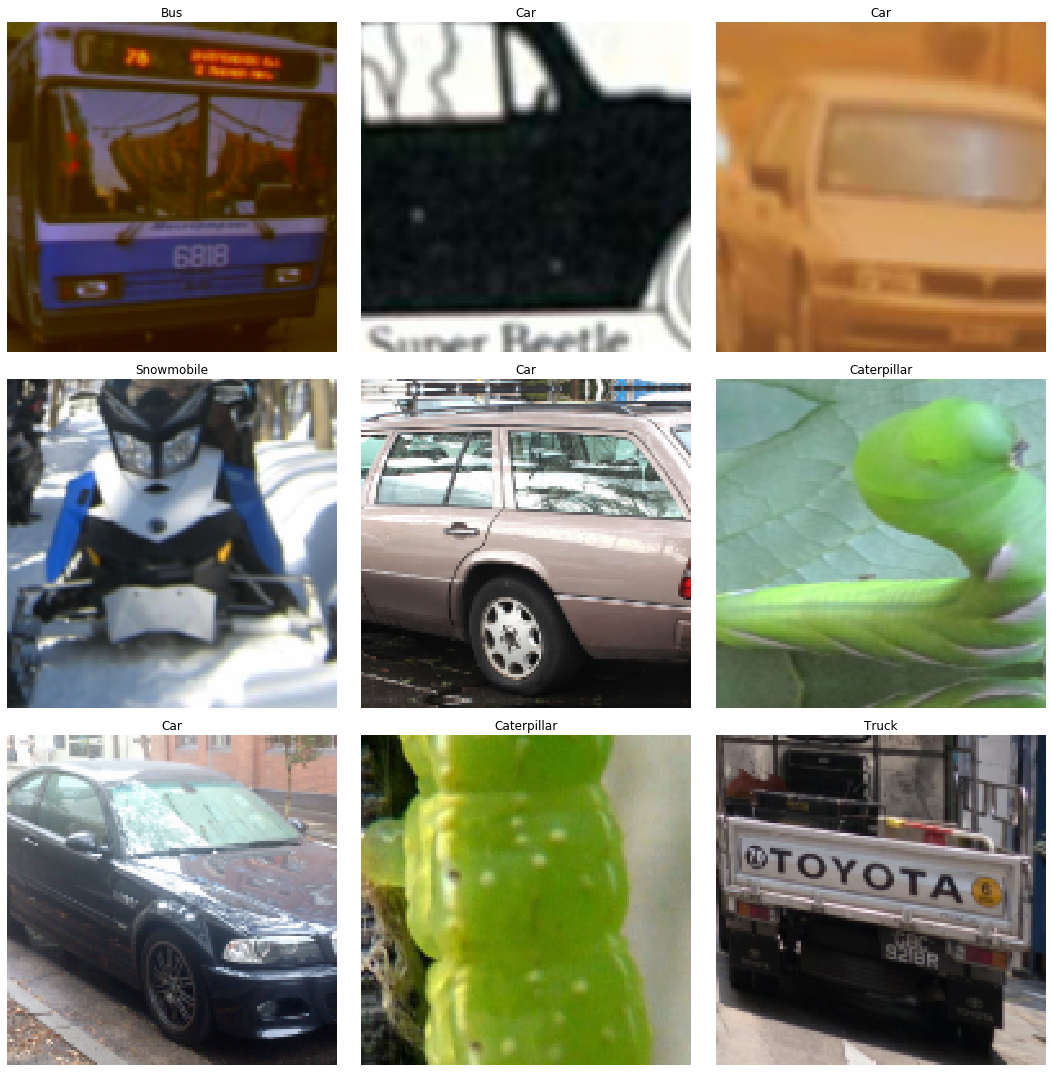

In [55]:
data = get_data(24, 128)

In [56]:
data

ImageDataBunch;

Train: LabelList (2244 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
Car,Boat,Boat,Truck,Bicycle
Path: /content/drive/My Drive/vehicle_classification/vehicle_classification_dataset;

Valid: LabelList (560 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
Motorcycle,Motorcycle,Taxi,Motorcycle,Car
Path: /content/drive/My Drive/vehicle_classification/vehicle_classification_dataset;

Test: LabelList (7958 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: EmptyLabelList
,,,,
Path: /content/drive/My Drive/vehicle_classification/vehicle_classification_dataset

In [0]:
learn = cnn_learner(data, models.resnet18 , pretrained=True, model_dir= model_path , metrics=[error_rate, accuracy], callback_fns=[partial(EarlyStoppingCallback, monitor='accuracy', min_delta=0.01, patience=5)])

In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,accuracy,time


In [0]:
learn.recorder.plot()

In [0]:
def do_fit(bs,sz,epochs,lr, freeze=True):
    learn.dbunch = get_data(bs, sz)
    if freeze:
        learn.freeze()
        learn.fit_one_cycle(3, slice(lr))
    learn.unfreeze()
    learn.fit_one_cycle(epochs, slice(lr))

In [0]:
do_fit(32, 92, 5, )

In [0]:
interp = ClassificationInterpretation.from_learner(densenet_pretrained)
from sklearn import metrics
print(metrics.classification_report(interp.y_true.numpy(), interp.pred_class.numpy(),target_names =data.classes))

In [0]:
preds,y=densenet_pretrained.get_preds(ds_type=DatasetType.Test)
preds = np.argmax(preds, axis = 1)
preds_classes = [data.classes[i] for i in preds]


In [0]:
submission = pd.DataFrame({ 'file': os.listdir('/content/drive/My Drive/plant_seedlings/plant_seedling_extract/test'), 'species': preds_classes })
submission.to_csv('test_classification_results.csv', index=False)
